In [246]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datasets import load_dataset
import librosa
import librosa.display
import IPython.display as ipd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [247]:
# setting seeds
SEED = 1234
np.random.seed = SEED
random.seed = SEED

# setting up directories
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True) 

## Read in data

In [248]:
# downloading data
ds = load_dataset('marsyas/gtzan', cache_dir=DATA_DIR)

In [249]:
ds = ds.shuffle(seed=SEED)
print('File count: ', ds['train'].num_rows)
print('Example element: ', ds['train'][0])

File count:  999
Example element:  {'file': '/home/dani/music-genre-classification/data/downloads/extracted/197117f2e99aab4d1bf3be1b5ec80c391a0e4c13c8af00243fabf205d3d449d6/genres/disco/disco.00014.wav', 'audio': {'path': '/home/dani/music-genre-classification/data/downloads/extracted/197117f2e99aab4d1bf3be1b5ec80c391a0e4c13c8af00243fabf205d3d449d6/genres/disco/disco.00014.wav', 'array': array([ 0.20974731,  0.13619995,  0.14807129, ..., -0.16918945,
       -0.19021606, -0.21813965]), 'sampling_rate': 22050}, 'genre': 3}


In [250]:
ipd.Audio(ds['train'][0]['file'])

## Processing file
1. loading with librosa
2. normalizing audio
3. segmenting audio
4. extracting features from segments

For all steps an example will be given that uses the first element of the dataset.

In [251]:
y, sr = librosa.load(ds['train'][0]['file']) # audio samples and sample rate
print(y.shape) # all data points
print(sr) # sample rate in 1 sec of audio

(661344,)
22050


In [252]:
normalized = librosa.util.normalize(y)
print(f'Before normalization: \n\tmax={np.max(y)} \n\tmin={np.min(y)}')
print(f'After normalization: \n\tmax={np.max(normalized)} \n\tmin={np.min(normalized)}')

Before normalization: 
	max=0.650054931640625 
	min=-0.667022705078125
After normalization: 
	max=0.9745619297027588 
	min=-1.0


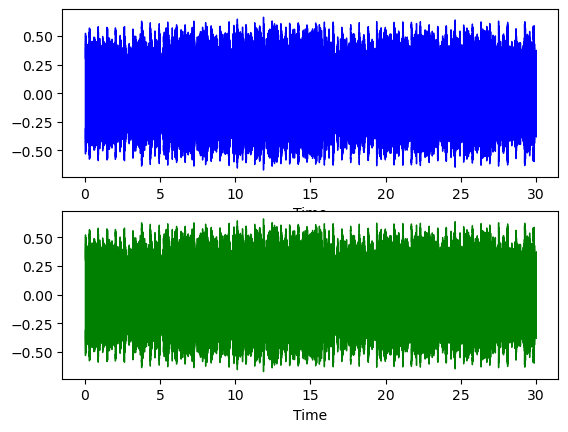

In [253]:
plt.subplot(2,1,1)
librosa.display.waveshow(y, sr=sr, color='b')
plt.subplot(2,1,2)
librosa.display.waveshow(y, sr=sr, color='g')
plt.show()

In [254]:
# segmentation
def segment_audio_data(audio, segment_num=10):
    segment_size = audio.shape[0]//segment_num

    segment_ranges = []
    for i in range(segment_num):
        segment_ranges.append((i*segment_size, (i+1)*segment_size))
    segment_ranges[-1] = (segment_ranges[-1][0], audio.shape[0]+1)
    
    return segment_ranges

segment_num = 10
segment_ranges = segment_audio_data(normalized, segment_num=segment_num)
print('Number of segments: ', segment_num)
print('First segment: ', segment_ranges[0])

Number of segments:  10
First segment:  (0, 66134)


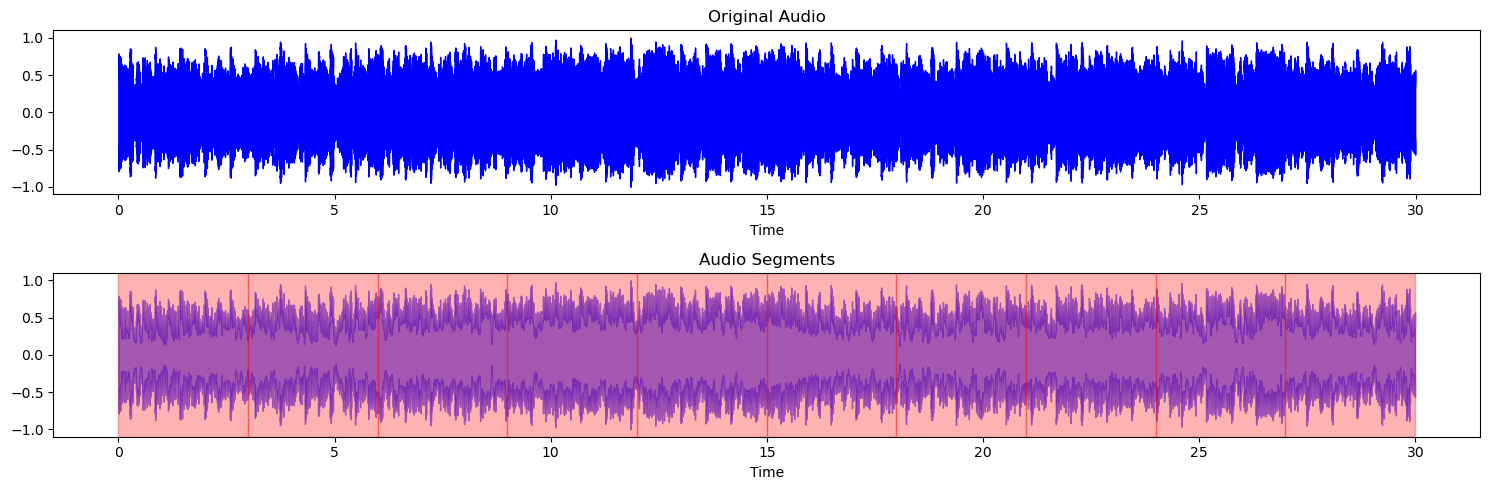

In [255]:
def visualize_audio_segments(audio, sr, segment_ranges):
    plt.figure(figsize=(15, 5))

    # Plot the entire audio waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio, sr=sr, color='b')
    plt.title('Original Audio')

    # Plot each segment in a different color
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(audio, sr=sr, alpha=0.5, color='b')  # Plot the entire audio as a background

    for start, end in segment_ranges:
        plt.axvspan(start/sr, end/sr, color='r', alpha=0.3)  # Highlight each segment

    plt.title('Audio Segments')
    plt.tight_layout()
    plt.show()

visualize_audio_segments(normalized, sr, segment_ranges)

In [256]:
# extracting MFCC, tempos and other features from audio data segments

def get_features(y, segment_ranges):
    '''
    Extracts features from a segment of the audio data
    Examples of features: MFCC, tempo, spectral centroid, etc.
    '''
    df = pd.DataFrame()

    for i, segment_range in enumerate(segment_ranges):
        
        # chroma_stft
        chroma_stft = librosa.feature.chroma_stft(y=y[segment_range[0]:segment_range[1]], sr=sr)
        df.loc[i, 'chroma_stft_mean'] = chroma_stft.mean()
        df.loc[i, 'chroma_stft_var'] = np.var(chroma_stft, axis=1).mean()
        
        # chroma_rms
        chroma_rms = librosa.feature.rms(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'rms_mean'] = chroma_rms.mean()
        df.loc[i, 'rms_var'] = np.var(chroma_rms, axis=1).mean()
        
        # spectral_centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'spectral_centroid_mean'] = spectral_centroid.mean()
        df.loc[i, 'spectral_centroid_var'] = np.var(spectral_centroid, axis=1).mean()
        
        # spectral_bandwidth
        chroma_bandwidth = librosa.feature.spectral_bandwidth(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'chroma_bandwidth_mean'] = chroma_bandwidth.mean()
        df.loc[i, 'chroma_bandwidth_var'] = np.var(chroma_bandwidth, axis=1).mean()
        
        # rolloff
        chroma_rolloff = librosa.feature.spectral_rolloff(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'chroma_rolloff_mean'] = chroma_rolloff.mean()
        df.loc[i, 'chroma_rolloff_var'] = np.var(chroma_rolloff, axis=1).mean()
        
        # zero_crossing_rate
        chroma_zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'chroma_zero_crossing_rate_mean'] = chroma_zero_crossing_rate.mean()
        df.loc[i, 'chroma_zero_crossing_rate_var'] = np.var(chroma_zero_crossing_rate, axis=1).mean()

        # Harmonics and perceptual mean
        chroma_harmony, chroma_perceptr = librosa.effects.hpss(y=y[segment_range[0]:segment_range[1]])
        df.loc[i, 'chroma_harmony_mean'] = chroma_harmony.mean()
        df.loc[i, 'chroma_harmony_var'] = chroma_harmony.var()
        df.loc[i, 'chroma_perceptr_mean'] = chroma_perceptr.mean()
        df.loc[i, 'chroma_perceptr_var'] = chroma_perceptr.var()

        # tempo
        df.loc[i, 'chroma_tempo'], _ = librosa.beat.beat_track(y=y[segment_range[0]:segment_range[1]], sr=sr)
    
        # mfcc
        n_mfcc = 10
        mfcc = librosa.feature.mfcc(y=y[segment_range[0]:segment_range[1]], sr=sr, n_mfcc=n_mfcc)
        for mfcc_idx in range(n_mfcc):
            df.loc[i, 'mffc_mean'+str(mfcc_idx+1)] = mfcc[mfcc_idx].mean()
            df.loc[i, 'mffc_var'+str(mfcc_idx+1)] = mfcc[mfcc_idx].var()
        
    return df
    
print(get_features(y, segment_ranges).loc[:5])

   chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0          0.448113         0.066745  0.160266  0.000929   
1          0.449155         0.054455  0.165770  0.001292   
2          0.456712         0.054404  0.175146  0.001086   
3          0.417191         0.042544  0.185149  0.001059   
4          0.372093         0.035207  0.187316  0.001045   
5          0.422987         0.056725  0.169891  0.001124   

   spectral_centroid_mean  spectral_centroid_var  chroma_bandwidth_mean  \
0             2904.195935          442785.385279            2727.308556   
1             3114.965373          446218.646228            2903.569302   
2             3243.560426          263989.771755            2800.617370   
3             3176.333297          125842.424234            2836.665061   
4             2956.997104          115337.939636            2748.982556   
5             3028.705792          215776.195956            2809.067016   

   chroma_bandwidth_var  chroma_rolloff_mean  chroma_

## Processing all files

In [270]:
def process_audio(row):
    try:
        y, sr = librosa.load(row['file'])
        normalized = librosa.util.normalize(y)

        segment_num = 10
        segment_ranges = segment_audio_data(normalized, segment_num=segment_num)

        feature_df = get_features(normalized, segment_ranges)

        features = feature_df.to_numpy()
        return {"X": features, "Y": row['genre']}
    except Exception as e:
        print(f"Exception occurred for {row['file']}: ", e)
        return None

In [271]:
processed_dataset = ds.map(process_audio, num_proc=4)
#processed_dataset = processed_dataset.filter(lambda row: row is not None)

Map (num_proc=4): 100%|██████████| 999/999 [21:06<00:00,  1.27s/ examples]


In [275]:
X_t = [example["X"] for example in processed_dataset['train']]
Y_t = [example["Y"] for example in processed_dataset['train']]

In [12]:
X = []
Y = []

# process all audio files
# Note - expected time to run: ~30min
# TODO - optimize for runtime
# TODO - data augmentation
for i, element in enumerate(ds['train']):
    if i % 50 == 0: print(f"Processed: {i}/{ds['train'].num_rows}")
    try:
        y, sr = librosa.load(element['file'])
        normalized = librosa.util.normalize(y)

        segment_num = 10
        segment_ranges = segment_audio_data(normalized, segment_num=segment_num)

        feature_df = get_features(normalized, segment_ranges)
        X.append(feature_df.to_numpy())
        Y.append(element['genre'])
    except Exception as e:
        print(f"Exception occured for {element['file']}: ", e)

Processed: 0/999
Processed: 50/999
Processed: 100/999
Processed: 150/999
Processed: 200/999
Processed: 250/999
Processed: 300/999
Processed: 350/999
Processed: 400/999
Processed: 450/999
Processed: 500/999
Processed: 550/999
Processed: 600/999
Processed: 650/999
Processed: 700/999
Processed: 750/999
Processed: 800/999
Processed: 850/999
Processed: 900/999
Processed: 950/999


In [13]:
X = np.array(X)
print(X.shape)
print('Files processed: ', X.shape[0])
print('Number of segments for a file: ', X.shape[1])
print('Number of features for a file: ', X.shape[2])

(999, 10, 37)
Files processed:  999
Number of segments for a file:  10
Number of features for a file:  37


In [75]:
# split data
train_prec = 0.7
val_prec = 0.15

train_size = int(X.shape[0]*train_prec)
val_size = int(X.shape[0]*val_prec)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (699, 10, 37)
X_val shape:  (149, 10, 37)
X_test shape:  (151, 10, 37)


In [76]:
Y_train = np.asarray(Y_train)
Y_val = np.asarray(Y_val)
Y_test = np.asarray(Y_test)

## Model training
1. create model
2. train model
3. evaluate model
4. enhance model and go back to step 2.

In [191]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical

In [78]:
genres = 10
Y_train = to_categorical(Y_train, genres)
Y_val = to_categorical(Y_val, genres)
Y_test = to_categorical(Y_test, genres)

In [214]:
# model creation
feature_num = X_train.shape[2]
print(f'Input shape: ({segment_num},{feature_num})')

model = Sequential([
    LSTM(
        units=128,
        activation='relu',
        return_sequences=True,
        input_shape=(segment_num, feature_num)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(
        units=128,
        activation='relu',
        return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(
        units=64,
        activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(
        units=128,
        activation='relu',
        kernel_initializer=HeNormal,
    ),
    BatchNormalization(),
    Dropout(0.5),
    Dense(genres, activation='softmax')  # Assuming 10 genres
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Input shape: (10,37)


In [215]:
# callbacks
# TODO - tensorboard callback
es = EarlyStopping(
    patience=10, 
    restore_best_weights=True, 
    start_from_epoch=5)
callbacks = [es]

In [216]:
# model train
BATCH_SIZE = 32
EPOCHS = 200

history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(X_val,Y_val)
)

Epoch 1/200
22/22 [==============================] - 4s 35ms/step - loss: 3.3255 - accuracy: 0.1102 - val_loss: 2.5595 - val_accuracy: 0.2282
Epoch 2/200
22/22 [==============================] - 0s 21ms/step - loss: 3.1383 - accuracy: 0.1216 - val_loss: 2.5362 - val_accuracy: 0.2550
Epoch 3/200
22/22 [==============================] - 0s 18ms/step - loss: 3.0117 - accuracy: 0.1431 - val_loss: 5.6078 - val_accuracy: 0.1678
Epoch 4/200
22/22 [==============================] - 0s 20ms/step - loss: 2.9166 - accuracy: 0.1531 - val_loss: 2.2808 - val_accuracy: 0.1611
Epoch 5/200
22/22 [==============================] - 0s 22ms/step - loss: 2.6591 - accuracy: 0.1831 - val_loss: 2.2178 - val_accuracy: 0.2081
Epoch 6/200
22/22 [==============================] - 1s 24ms/step - loss: 2.6501 - accuracy: 0.1946 - val_loss: 2.1217 - val_accuracy: 0.2282
Epoch 7/200
22/22 [==============================] - 0s 20ms/step - loss: 2.5977 - accuracy: 0.1760 - val_loss: 2.1998 - val_accuracy: 0.2148
Epoch 

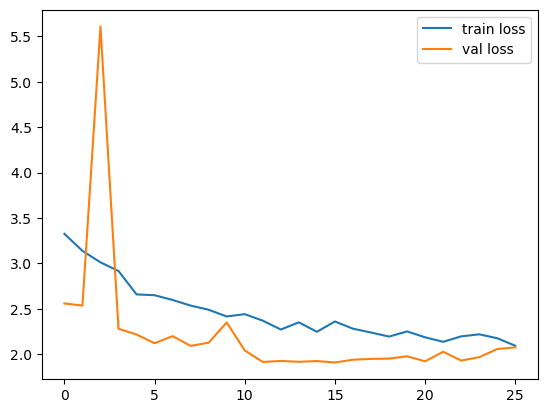

In [217]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

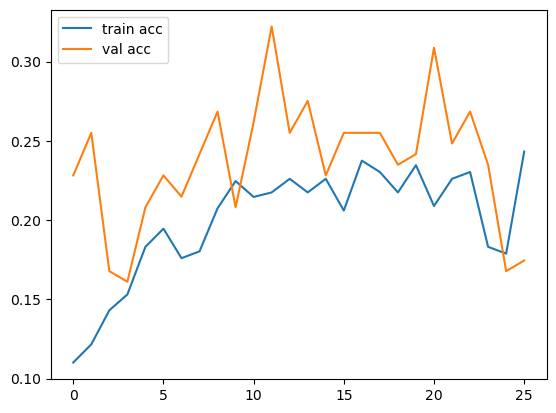

In [218]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### Evaluation

In [219]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [220]:
Y_pred = model.predict(X_test)

5/5 [==============================] - 0s 8ms/step


In [221]:
Y_true = Y_test.argmax(axis=1)
Y_pred = Y_pred.argmax(axis=1)

print(f'Y_true shape: {Y_true.shape} (type: {type(Y_true[0])})')
print(f'Y_pred shape: {Y_pred.shape} (type: {type(Y_pred[0])})')

Y_true shape: (151,) (type: <class 'numpy.int64'>)
Y_pred shape: (151,) (type: <class 'numpy.int64'>)


In [233]:
# 1.baseline - predicting the most common class in the test set
labels, counts = np.unique(Y_true, return_counts=True)
baseline_acc = (counts.sum() / counts.max()) / 100
print(f'1.Baseline: predicting the most common label, achieved accuracy: {baseline_acc:0.2%}')

# 2.baseline - predicting randomly
print('2.Baseline: random prediction')
random_pred_num = 10
for i in range(random_pred_num):
    random_pred = np.random.randint(0, 10, size=Y_true.shape[0])
    print(f'\t{i}.accuracy: {accuracy_score(Y_true, random_pred):0.2%}')

1.Baseline: predicting the most common label, achieved accuracy: 7.95%
2.Baseline: random prediction
	0.accuracy: 9.27%
	1.accuracy: 5.30%
	2.accuracy: 9.93%
	3.accuracy: 10.60%
	4.accuracy: 15.23%
	5.accuracy: 7.95%
	6.accuracy: 9.27%
	7.accuracy: 13.25%
	8.accuracy: 9.27%
	9.accuracy: 7.95%


In [234]:
# model evaluation 
print(f'Accuracy: {accuracy_score(Y_true, Y_pred):0.2%}')
print(f'Precision: {precision_score(Y_true, Y_pred, average="macro"):0.2%}')
print(f'Recall: {recall_score(Y_true, Y_pred, average="macro"):0.2%}')
print(f'F1: {f1_score(Y_true, Y_pred, average="macro")}')

Accuracy: 25.17%
Precision: 17.43%
Recall: 27.39%
F1: 0.1925305498880713


/home/dani/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [130]:
# covariance matrix # TODO